<a href="https://colab.research.google.com/github/waswapeter/CEE_Class-Codes-Data/blob/main/Peter_Wasswa_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FALLS LAKE SIMULATION PROJECT BY PETER WASSWA**

**Load required packages and clone dataset from Peter's github**

In [ ]:
##Import relevant packages
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import os
import pandas as pd

!git clone https://github.com/waswapeter/Falls_Lake.git

os.chdir("Falls_Lake")

files = os.listdir()
csv_files = [file for file in files if file.endswith('.csv')]

Cloning into 'Falls_Lake'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 42 (delta 15), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (42/42), 6.53 MiB | 7.17 MiB/s, done.
Resolving deltas: 100% (15/15), done.


**Create Dataframe to store simulation results**

In [ ]:
# storage the dataframes
reservoir_dataframe = {}

for file in csv_files:
    # Get the reservoir name by removing the .csv extension
    reservoir_name = os.path.splitext(file)[0][:3]
    # Load the CSV and store it in the dictionary
    reservoir_dataframe[reservoir_name] = pl.read_csv(file)


for reservoir, df in reservoir_dataframe.items():
    print(f"{reservoir}")
    print(f"Total Dimensions: {df.shape}")
    print(df.head(), "\n")

FLR
Total Dimensions: (4383, 6)
shape: (5, 6)
┌───────────┬─────────────────┬────────────────────┬─────────────┬─────────────────┬────────────┐
│ datetime  ┆ Guide Target_ft ┆ Reservoir Level_ft ┆ outflow_cfs ┆ WaterSupply_cfs ┆ inflow_cfs │
│ ---       ┆ ---             ┆ ---                ┆ ---         ┆ ---             ┆ ---        │
│ str       ┆ f64             ┆ f64                ┆ i64         ┆ i64             ┆ i64        │
╞═══════════╪═════════════════╪════════════════════╪═════════════╪═════════════════╪════════════╡
│ 10/1/2010 ┆ 251.5           ┆ 250.11             ┆ 96          ┆ 58              ┆ 907        │
│ 10/2/2010 ┆ 251.5           ┆ 250.09             ┆ 96          ┆ 59              ┆ 38         │
│ 10/3/2010 ┆ 251.5           ┆ 250.11             ┆ 96          ┆ 70              ┆ 283        │
│ 10/4/2010 ┆ 251.5           ┆ 250.05             ┆ 96          ┆ 56              ┆ 199        │
│ 10/5/2010 ┆ 251.5           ┆ 250.01             ┆ 96          ┆ 56   

**Generate timeseries for Falls Lake Daily Inflows and Outflows from 2010 to 2022**

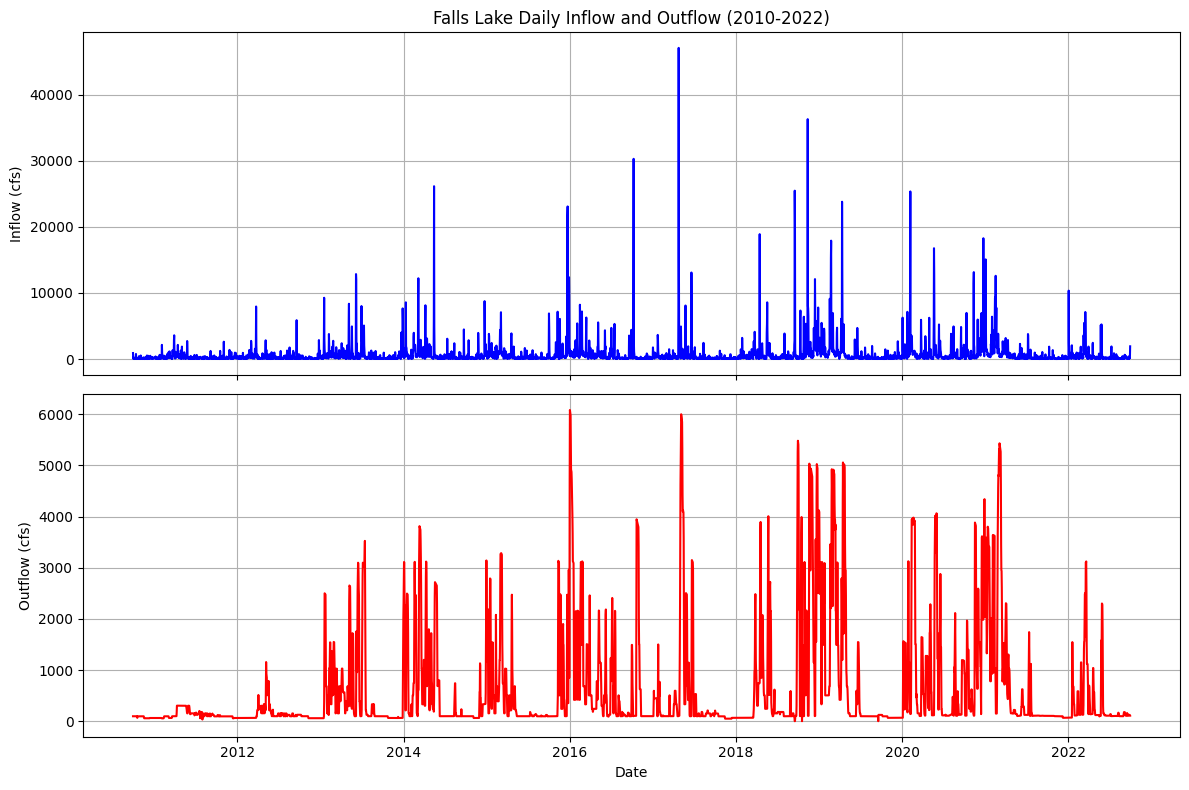

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Obtain inflow and outflow data from reservoir_dataframe

inflow = reservoir_dataframe['FLR'].get_column('inflow_cfs').to_numpy()
outflow = reservoir_dataframe['FLR'].get_column('outflow_cfs').to_numpy()

# Generate date range from 2010-09-30 to 2022-09-30 on daily basis

date_range = np.arange(np.datetime64("2010-09-30"), np.datetime64("2022-09-30"), np.timedelta64(1, 'D'))

# Create the subplot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)  # 2 rows, 1 column

# Plot inflow
ax1.plot(date_range, inflow, label='Inflow', color='blue')
ax1.set_ylabel('Inflow (cfs)')
ax1.set_title('Falls Lake Daily Inflow and Outflow (2010-2022)')
ax1.grid(True)

# Plot outflow
ax2.plot(date_range, outflow, label='Outflow', color='red')
ax2.set_ylabel('Outflow (cfs)')
ax2.set_xlabel('Date')
ax2.grid(True)

plt.tight_layout()
plt.show()

**Generate Falls Lake Attributes**

In [ ]:
reservoir_capacity = pl.DataFrame(
  {
    'Name': ['Falls Lake Reservoir'],
    'Abbreviation': ['FLR'],
    'Agency': ['USACE'],
    'Capacity (TAF)': ['1020.98']
  }
).with_columns(
    pl.col('Capacity (TAF)').cast(pl.Float64)
)
reservoir_capacity

Name,Abbreviation,Agency,Capacity (TAF)
str,str,str,f64
"""Falls Lake Reservoir""","""FLR""","""USACE""",1020.98


** Generate Reservoir Mass Balance Function to simulate Falls Lake Storage over time**

In [ ]:
def simulate_reservoir(reservoir_dataframe, reservoir_capacity, flood, MEF):
    """
    Calculate the reservoir mass balance and simulate the storage over time.

    Parameters:
    inflow: np.array - Inflow data in cfs
    outflow: np.array - Outflow data in cfs
    S: float - Maximum storage capacity of the reservoir in TAF
    sim_step: int - Simulation time step in seconds (default: 86400 seconds = 1 day)
    initial_storage: float - Initial percentage of maximum storage (default: 90%)

    Returns:
    storage_timeseries: np.array - Time series of reservoir storage
    flood_days: float - Average annual number of days storage exceeds maximum capacity
    """
    #Parameters:
    sim_step=86400
    initial_storage=0.9
    inflow = reservoir_dataframe['FLR'].get_column('inflow_cfs').to_numpy()
    outflow = reservoir_dataframe['FLR'].get_column('outflow_cfs').to_numpy()
    S = reservoir_capacity['Capacity (TAF)'][0]# Access the first element of the Series
    # Conversion factor from cfs to thousand acre-feet per day (TAF/day)
    cfs_to_tafd = 2.29568411 * 10**-5 * sim_step/1000

    # Length of the simulation horizon
    H = len(inflow)

    # Initialize storage
    s = np.zeros(H + 1)  # Storage time series

    # Initialize storage to 90% of the maximum capacity
    s[0] = S * initial_storage

    # Initialize flood_days to 0 before the loops
    flood_days = 0

    for t in range(H):
        # Mass balance: update storage based on inflow, outflow
        s[t+1] = s[t] + (inflow[t] - outflow[t]) * cfs_to_tafd

        # Apply physical constraints: no negative storage and no storage above max capacity
        s[t+1] = min(max(0, s[t+1]), S)

    return s # Return the calculated storage timeseries

def simulate_reservoir_mass_balance(reservoir_dataframe, reservoir_capacity, flood, MEF):
    storage_timeseries_reservoir = {}
    for key in reservoir_dataframe:
        inflow = reservoir_dataframe[key]['inflow_cfs'].to_numpy()  # inflow in cfs
        outflow = reservoir_dataframe[key]['outflow_cfs'].to_numpy()  # outflow in cfs
        S = reservoir_capacity.filter(pl.col("Abbreviation") == key)['Capacity (TAF)'][0]  # maximum storage capacity in TAF

        #Call the simulate_reservoir function with flood=False, MEF=False
        storage_timeseries = simulate_reservoir(reservoir_dataframe, reservoir_capacity, flood=False, MEF=False)



**Simulate Falls Lake and obtain storage timeseries, flood_days and MEF_deficit_days**

In [ ]:
def simulate_reservoir_mass_balance(reservoir_dataframe, reservoir_capacity, flood, MEF):
    storage_timeseries_reservoir = {}
    flood_days_reservoir = {}
    MEF_deficit_days_reservoir = {}
    for key in reservoir_dataframe:
        inflow = reservoir_dataframe[key]['inflow_cfs'].to_numpy()  # inflow in cfs
        outflow = reservoir_dataframe[key]['outflow_cfs'].to_numpy()  # outflow in cfs
        S = reservoir_capacity.filter(pl.col("Abbreviation") == key)['Capacity (TAF)'][0]  # maximum storage capacity in TAF

        if flood == False and MEF == False:
            # Call the reservoir mass balance function (simulate_reservoir)
            storage_timeseries = simulate_reservoir(reservoir_dataframe, reservoir_capacity, flood=False, MEF=False)


            # Append the key and corresponding storage_timeseries to the dictionary
            storage_timeseries_reservoir[key] = storage_timeseries
            print(f"Simulated storage for {key} ({S} TAF)")

            # Append the key and corresponding storage_timeseries to the dictionary
            storage_timeseries_reservoir[key] = storage_timeseries
            print(f"Simulated storage for {key} ({S} TAF)")

        elif flood == True and MEF == False:
            storage_timeseries, annual_flood_days = simulate_reservoir_mass_balance(inflow, outflow, S, flood=True)  # flood=True to calculate storage and flood days
            # Append the key and corresponding storage_timeseries to the dictionary
            storage_timeseries_reservoir[key] = storage_timeseries
            # Store flood days for each reservoir
            flood_days_reservoir[key] = annual_flood_days
            print(f"Simulated storage and flood days for {key} ({S} TAF)")

        elif flood == False and MEF == True:
            storage_timeseries, annual_MEF_deficit_days = simulate_reservoir_mass_balance(inflow, outflow, S, flood=False)  # flood=False, but calculate MEF deficits
            storage_timeseries_reservoir[key] = storage_timeseries
            MEF_deficit_days_reservoir[key] = annual_MEF_deficit_days
            print(f"Simulated storage and MEF days for {key} ({S} TAF)")

        elif flood == True and MEF == True:
            storage_timeseries, annual_flood_days = simulate_reservoir_mass_balance(inflow, outflow, S, flood=True)  # flood=True to calculate storage and flood days
            _, annual_MEF_deficit_days = simulate_reservoir_mass_balance(inflow, outflow, S, flood=False) # flood=False, but calculate MEF deficits
            storage_timeseries_reservoir[key] = storage_timeseries
            flood_days_reservoir[key] = annual_flood_days
            MEF_deficit_days_reservoir[key] = annual_MEF_deficit_days
            print(f"Simulated storage, flood days, and MEF days for {key} ({S} TAF)")

    # Always return the storage timeseries dictionary
    return storage_timeseries_reservoir #Getting simulated storage in each reservoir
storage_timeseries_reservoir = simulate_reservoir_mass_balance(reservoir_dataframe, reservoir_capacity, flood = False, MEF = False)



Simulated storage for FLR (1020.98 TAF)
Simulated storage for FLR (1020.98 TAF)


**Make a plot simulated Falls Lake Storage Trajectory**

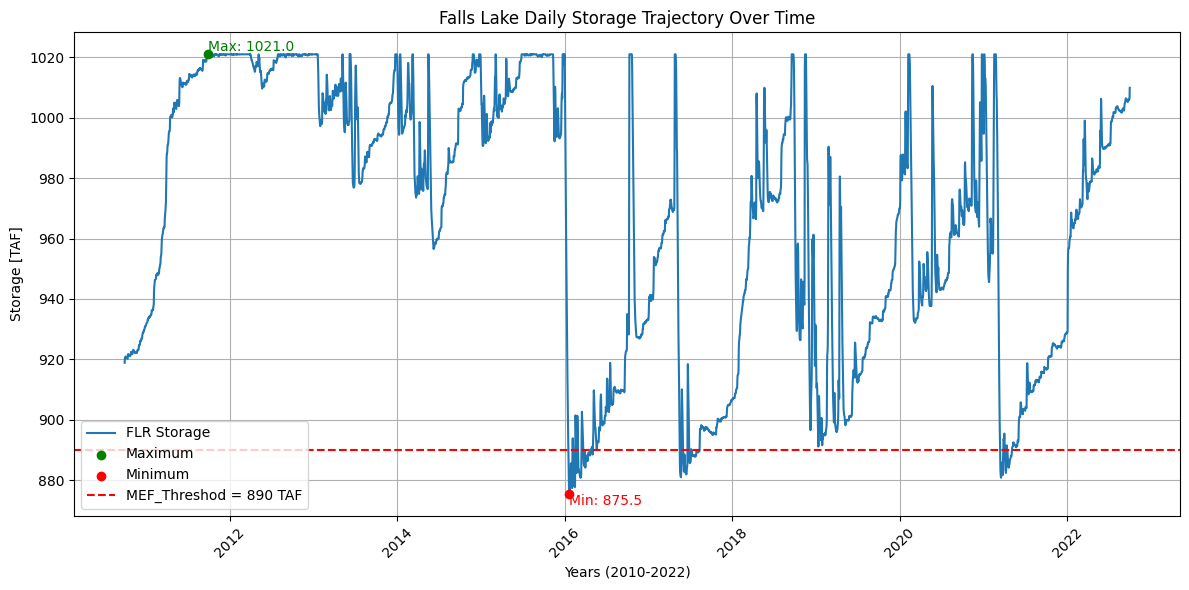

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

selected_reservoir = 'FLR'
storage = storage_timeseries_reservoir[selected_reservoir]

# Find the maximum point
max_value = np.max(storage)
max_index = np.argmax(storage)

# Find the minimum point
min_value = np.min(storage)
min_index = np.argmin(storage)
# Generate date range from 2015-09-30 to 2021-09-30
# Include the end date by adding a day using timedelta64
date_range = np.arange(np.datetime64("2010-09-30"), np.datetime64("2022-09-30") + np.timedelta64(1, 'D'), np.timedelta64(1, 'D'))

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(date_range, storage, label=f'{selected_reservoir} Storage')
# Add a scatter plot for the maximum point (green dot)
plt.scatter(date_range[max_index], max_value, color='green', zorder=5, label='Maximum')
plt.scatter(date_range[min_index], min_value, color='red', zorder=5, label='Minimum')
plt.title('Falls Lake Daily Storage Trajectory Over Time')
# Add text for max_value
plt.text(date_range[max_index], max_value, f'Max: {max_value:.1f}', ha='left', va='bottom', color='green')
# Add text for min_value
plt.text(date_range[min_index], min_value, f'Min: {min_value:.1f}', ha='left', va='top', color='red')

# Add a horizontal dashed line at storage = 890 TAF
plt.axhline(y=890, color='red', linestyle='--', label='MEF_Threshod = 890 TAF')

plt.xlabel('Years (2010-2022)')
plt.ylabel('Storage [TAF]')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Add gridlines
plt.legend()
plt.tight_layout()
plt.show()

**Finding years with highest and lowest simulated Falls Lake Storage values**

In [ ]:
storage_timeseries = storage_timeseries_reservoir['FLR']
date_range = np.arange(np.datetime64("2010-09-30"), np.datetime64("2022-09-30") + np.timedelta64(1, 'D'), np.timedelta64(1, 'D'))
storage_series = pd.Series(storage_timeseries, index=date_range)
yearly_max = storage_series.groupby(storage_series.index.year).max()
yearly_min = storage_series.groupby(storage_series.index.year).min()

# Get the years with the highest and lowest values
max_year = yearly_max.idxmax()
min_year = yearly_min.idxmin()

print(f"Year with highest storage: {max_year}, Value: {yearly_max.max():.2f} TAF")
print(f"Year with lowest storage: {min_year}, Value: {yearly_min.min():.2f} TAF")

Year with highest storage: 2011, Value: 1020.98 TAF
Year with lowest storage: 2016, Value: 875.47 TAF


**Plot the trend of simulated storage over Falls Lake**

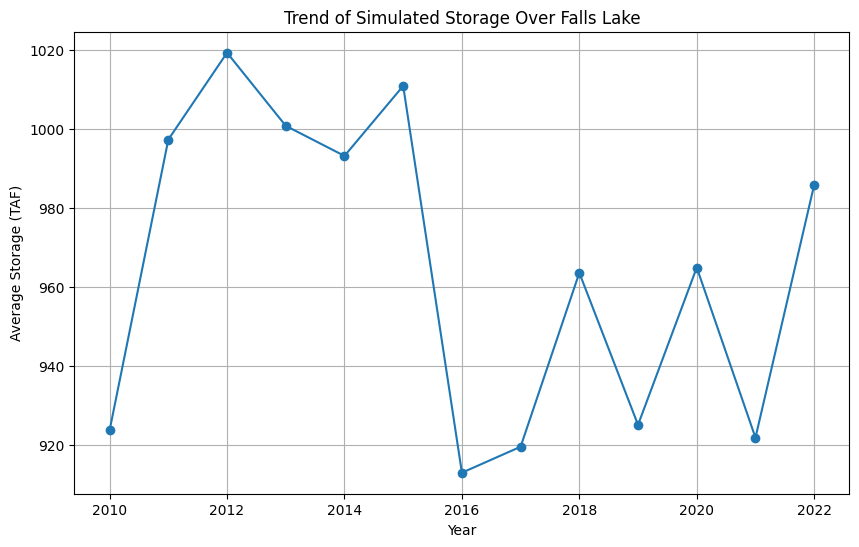

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

storage_timeseries = storage_timeseries_reservoir['FLR']
date_range = np.arange(np.datetime64("2010-09-30"), np.datetime64("2022-09-30") + np.timedelta64(1, 'D'), np.timedelta64(1, 'D'))
storage_series = pd.Series(storage_timeseries, index=date_range)
yearly_avg_storage = storage_series.groupby(storage_series.index.year).mean()
plt.figure(figsize=(10, 6))
plt.plot(yearly_avg_storage.index, yearly_avg_storage.values, marker='o')
plt.title('Trend of Simulated Storage Over Falls Lake')
plt.xlabel('Year')
plt.ylabel('Average Storage (TAF)')
plt.grid(True)
plt.show()

**Compute the significance of the trend of simulated storage**

In [ ]:
import numpy as np
from scipy import stats
years = yearly_avg_storage.index.to_numpy()
storage_values = yearly_avg_storage.values
slope, intercept, r_value, p_value, std_err = stats.linregress(years, storage_values)
print(f"Slope: {slope:.2f}")
print(f"P-value: {p_value:.3f}")
if p_value < 0.05:
    print("The trend in storage is statistically significant.")
else:
    print("The trend in storage is not statistically significant.")

Slope: -3.29
P-value: 0.276
The trend in storage is not statistically significant.


**Generate a plot for number of flood days simulated over Falls Lake**

Flood Dates and Storage Values:
Date: 2011-09-28, Storage: 1020.98 TAF
Date: 2011-10-01, Storage: 1020.98 TAF
Date: 2011-10-03, Storage: 1020.98 TAF
Date: 2011-10-19, Storage: 1020.98 TAF
Date: 2011-10-28, Storage: 1020.98 TAF
Date: 2011-10-29, Storage: 1020.98 TAF
Date: 2011-10-31, Storage: 1020.98 TAF
Date: 2011-11-04, Storage: 1020.98 TAF
Date: 2011-11-05, Storage: 1020.98 TAF
Date: 2011-11-06, Storage: 1020.98 TAF
Date: 2011-11-07, Storage: 1020.98 TAF
Date: 2011-11-17, Storage: 1020.98 TAF
Date: 2011-11-18, Storage: 1020.98 TAF
Date: 2011-11-19, Storage: 1020.98 TAF
Date: 2011-11-23, Storage: 1020.98 TAF
Date: 2011-11-28, Storage: 1020.98 TAF
Date: 2011-11-29, Storage: 1020.98 TAF
Date: 2011-11-30, Storage: 1020.98 TAF
Date: 2011-12-01, Storage: 1020.98 TAF
Date: 2011-12-02, Storage: 1020.98 TAF
Date: 2011-12-07, Storage: 1020.98 TAF
Date: 2011-12-08, Storage: 1020.98 TAF
Date: 2011-12-09, Storage: 1020.98 TAF
Date: 2011-12-10, Storage: 1020.98 TAF
Date: 2011-12-16, Storage: 1020.

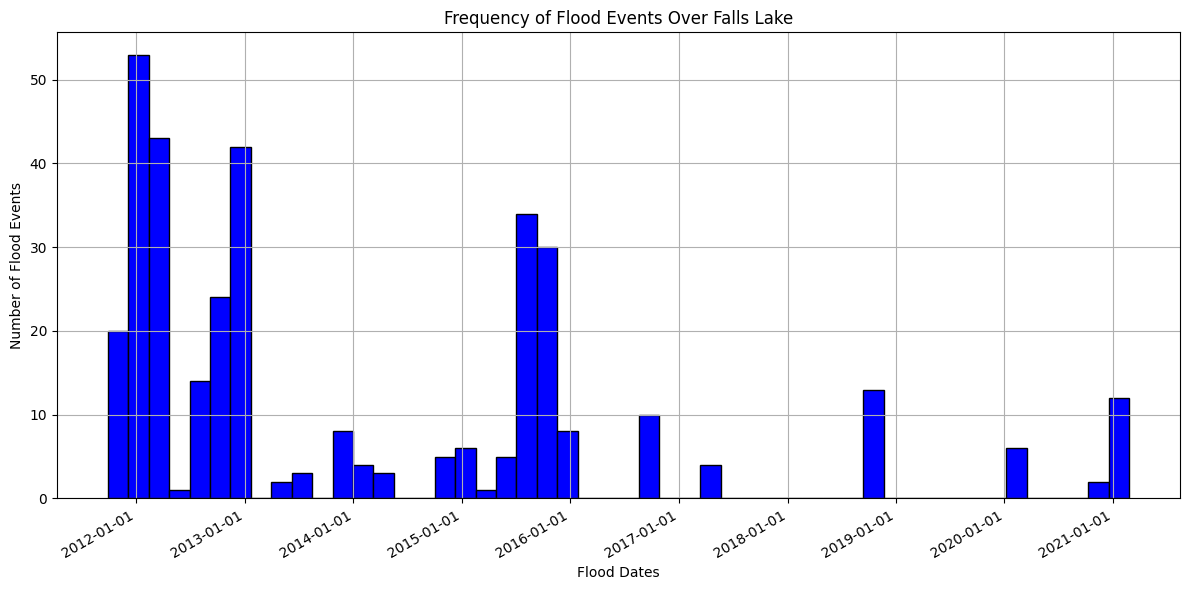

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates # Import the mdates module

# Define your flood threshold
flood_threshold = 1020.98

# Initialize an array to store flood days (1 for flood day, 0 for non-flood day)
flood_days_array = np.zeros_like(storage_timeseries_reservoir['FLR'])

# Loop through the storage timeseries to identify individual flood days
for i, storage in enumerate(storage_timeseries_reservoir['FLR']):
    if storage >= flood_threshold:
        flood_days_array[i] = 1

# To get a list of the indices (dates) of flood days:
flood_day_indices = np.where(flood_days_array == 1)[0]

date_range = np.arange(np.datetime64("2010-09-30"), np.datetime64("2022-09-30") + np.timedelta64(1, 'D'), np.timedelta64(1, 'D'))
# Get the specific dates of flood events
flood_dates = date_range[flood_day_indices]

# Print specific dates with their corresponding flood events (storage values)
print("Flood Dates and Storage Values:")
for index in flood_day_indices:
    date = date_range[index]
    storage_value = storage_timeseries_reservoir['FLR'][index]
    print(f"Date: {date}, Storage: {storage_value:.2f} TAF")  # Format storage to 2 decimal places

# Extract storage values for flood events
flood_storage_values = storage_timeseries_reservoir['FLR'][flood_day_indices]

# Create a histogram of flood events by date
plt.figure(figsize=(12, 6))
plt.hist(flood_dates, bins=50, edgecolor='black',color='blue')

# Format x-axis to display dates properly
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Rotate x-axis labels for better readability

plt.title('Frequency of Flood Events Over Falls Lake')
plt.xlabel('Flood Dates')
plt.ylabel('Number of Flood Events')
plt.grid(True)
plt.tight_layout()
plt.show()

**Find the year with highest and lowest number of simulated flood days over Falls Lake**

In [ ]:
def calculate_flood_days(storage_timeseries, flood_threshold, year):
    """Calculates the number of flood days for a given year."""
    # Filter storage timeseries for the specified year
    storage_year = storage_timeseries[storage_timeseries.index.year == year]

    # Count flood days (days when storage exceeds threshold)
    flood_days = (storage_year >= flood_threshold).sum()

    return flood_days

flood_threshold = 1020.98 # Falls Lake capacity
flood_days_by_year = {}
for year in range(2010, 2022):
    flood_days_by_year[year] = calculate_flood_days(storage_series, flood_threshold, year)

# Convert flood_days_by_year to a pandas Series for easier manipulation
flood_days_series = pd.Series(flood_days_by_year)

# Get the years with the highest and lowest flood days
max_flood_year = flood_days_series.idxmax()
min_flood_year = flood_days_series.idxmin()

print(f"Year with highest flood days: {max_flood_year}, Flood Days: {flood_days_series.max()}")
print(f"Year with lowest flood days: {min_flood_year}, Flood Days: {flood_days_series.min()}")


Year with highest flood days: 2012, Flood Days: 140
Year with lowest flood days: 2010, Flood Days: 0


**Plot the trend of flood days over Falls Lake**

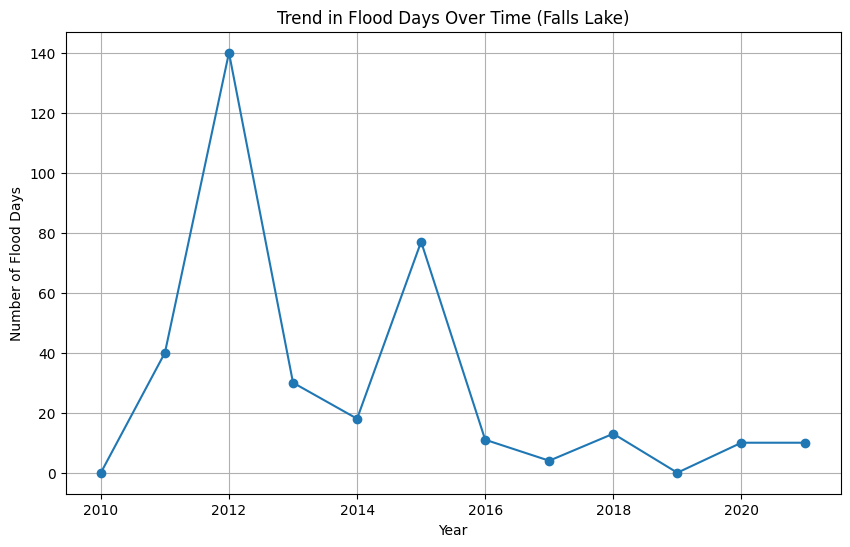

In [ ]:
import matplotlib.pyplot as plt

# Plot the flood days over time
plt.figure(figsize=(10, 6))
plt.plot(flood_days_series.index, flood_days_series.values, marker='o')
plt.title('Trend in Flood Days Over Time (Falls Lake)')
plt.xlabel('Year')
plt.ylabel('Number of Flood Days')
plt.grid(True)
plt.show()

**Compute Mann-Kendall and the significance of the trend of flood days**

In [ ]:
import scipy.stats as stats
import numpy as np

flood_days = flood_days_series.values
years = flood_days_series.index.to_numpy()  # Get the years

# Perform the Mann-Kendall test
try:
    trend, p, z = stats.kendalltau(flood_days, np.arange(len(flood_days)))
except ValueError:
    trend, p = stats.kendalltau(flood_days, np.arange(len(flood_days)))
    z = np.nan  # Assign NaN to z if it's not returned

# Print the results
print(f"Mann-Kendall Trend (Flood Days): {trend}")
print(f"p-value (Flood Days): {p:.3f}")
print(f"z-statistic (Flood Days): {z:.2f}")

# Interpretation
if p < 0.05:
    print("The trend in flood days is statistically significant.")
else:
    print("The trend in flood days is not statistically significant.")

Mann-Kendall Trend (Flood Days): -0.3692744729379982
p-value (Flood Days): 0.098
z-statistic (Flood Days): nan
The trend in flood days is not statistically significant.


**Generate a plot for number of MEF deficit days simulated over Falls Lake**

MEF Dates and Storage Values:
Date: 2016-01-17, Storage: 889.84 TAF
Date: 2016-01-18, Storage: 884.55 TAF
Date: 2016-01-19, Storage: 878.83 TAF
Date: 2016-01-20, Storage: 875.47 TAF
Date: 2016-01-21, Storage: 875.56 TAF
Date: 2016-01-22, Storage: 877.66 TAF
Date: 2016-01-23, Storage: 877.57 TAF
Date: 2016-01-24, Storage: 877.18 TAF
Date: 2016-01-25, Storage: 877.64 TAF
Date: 2016-01-26, Storage: 878.51 TAF
Date: 2016-01-27, Storage: 882.72 TAF
Date: 2016-01-28, Storage: 885.58 TAF
Date: 2016-01-29, Storage: 884.63 TAF
Date: 2016-01-30, Storage: 882.22 TAF
Date: 2016-01-31, Storage: 879.56 TAF
Date: 2016-02-01, Storage: 878.42 TAF
Date: 2016-02-02, Storage: 877.41 TAF
Date: 2016-02-03, Storage: 881.72 TAF
Date: 2016-02-07, Storage: 889.45 TAF
Date: 2016-02-08, Storage: 886.41 TAF
Date: 2016-02-09, Storage: 883.21 TAF
Date: 2016-02-10, Storage: 879.79 TAF
Date: 2016-02-11, Storage: 878.03 TAF
Date: 2016-02-12, Storage: 878.09 TAF
Date: 2016-02-13, Storage: 878.10 TAF
Date: 2016-02-14, St

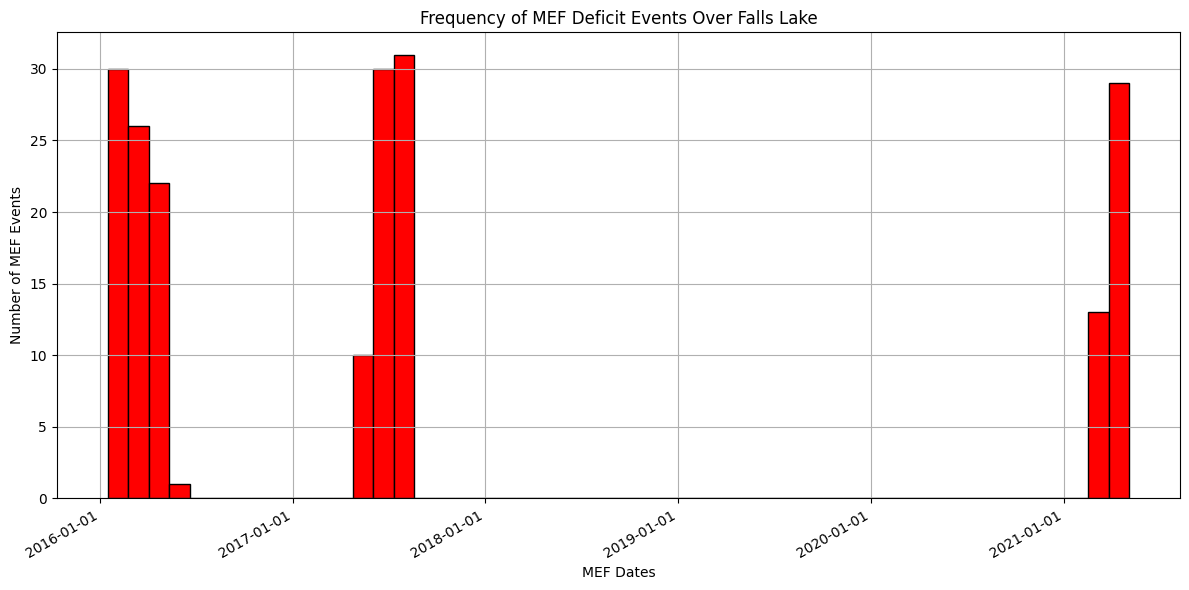

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates # Import the mdates module

MEF_threshold = 890  # Falls Lake MEF threshold

# Initialize an array to store MEF days (1 for MEF day, 0 for non-MEF day)
MEF_days_array = np.zeros_like(storage_timeseries_reservoir['FLR'])

# Loop through the storage timeseries to identify individual MEF days
for i, storage in enumerate(storage_timeseries_reservoir['FLR']):
    if storage < MEF_threshold:
        MEF_days_array[i] = 1

# To get a list of the indices (dates) of MEF days:
MEF_day_indices = np.where(MEF_days_array == 1)[0]

date_range = np.arange(np.datetime64("2010-09-30"), np.datetime64("2022-09-30") + np.timedelta64(1, 'D'), np.timedelta64(1, 'D'))
# Get the specific dates of MEF events
MEF_dates = date_range[MEF_day_indices]


# Print specific dates with their corresponding MEF events (storage values)
print("MEF Dates and Storage Values:")
for index in MEF_day_indices:
    date = date_range[index]
    storage_value = storage_timeseries_reservoir['FLR'][index]  # Assuming 'FLR' is your reservoir key
    print(f"Date: {date}, Storage: {storage_value:.2f} TAF")  # Format storage to 2 decimal places

# Extract storage values for MEF events
MEF_storage_values = storage_timeseries_reservoir['FLR'][MEF_day_indices]  # Assuming 'FLR' is your reservoir key

# Create a histogram of MEF events by date
plt.figure(figsize=(12, 6))
plt.hist(MEF_dates, bins=50, edgecolor='black',color='red')  # Adjust bins as needed

# Format x-axis to display dates properly
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Rotate x-axis labels for better readability

plt.title('Frequency of MEF Deficit Events Over Falls Lake')
plt.xlabel('MEF Dates')
plt.ylabel('Number of MEF Events')
plt.grid(True)
plt.tight_layout()
plt.show()

**Find the year with highest and lowest number of simulated MEF deficit days over Falls Lake**

In [ ]:
def calculate_mef_deficit_days(storage_timeseries, mef_threshold, year):
    """Calculates the number of MEF deficit days for a given year."""
    # Filter storage timeseries for the specified year
    storage_year = storage_timeseries[storage_timeseries.index.year == year]

    # Count MEF deficit days (days when storage is below threshold)
    mef_deficit_days = (storage_year < mef_threshold).sum()

    return mef_deficit_days

mef_threshold = 890  # Falls Lake MEF threshold
mef_deficit_days_by_year = {}
for year in range(2010, 2023):  # Adjust the year range as needed
    mef_deficit_days_by_year[year] = calculate_mef_deficit_days(storage_series, mef_threshold, year)

# Convert mef_deficit_days_by_year to a pandas Series for easier manipulation
mef_deficit_days_series = pd.Series(mef_deficit_days_by_year)

# Get the years with the highest and lowest MEF deficit days
max_mef_deficit_year = mef_deficit_days_series.idxmax()
min_mef_deficit_year = mef_deficit_days_series.idxmin()

print(f"Year with highest MEF deficit days: {max_mef_deficit_year}, MEF Deficit Days: {mef_deficit_days_series.max()}")
print(f"Year with lowest MEF deficit days: {min_mef_deficit_year}, MEF Deficit Days: {mef_deficit_days_series.min()}")

Year with highest MEF deficit days: 2016, MEF Deficit Days: 79
Year with lowest MEF deficit days: 2010, MEF Deficit Days: 0


**Plot trend of MEF deficit days**

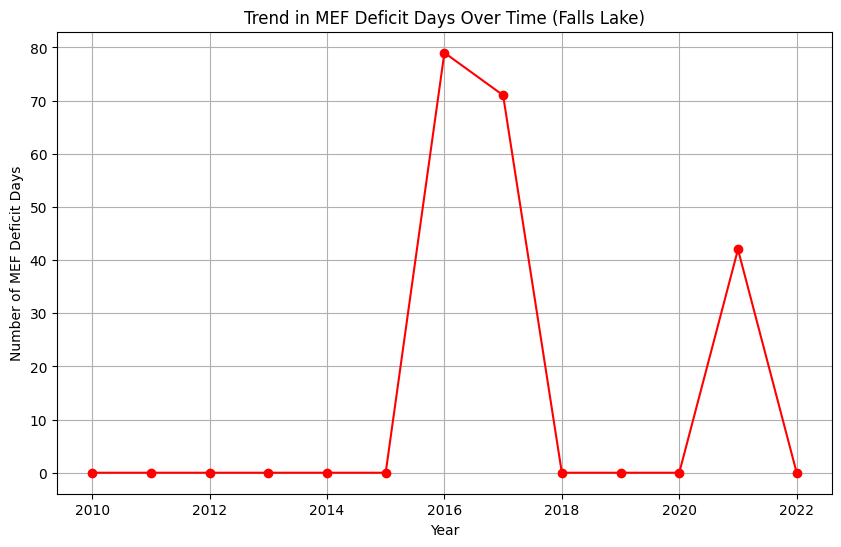

In [ ]:
import matplotlib.pyplot as plt

# Plot the MEF deficit days over time
plt.figure(figsize=(10, 6))
plt.plot(mef_deficit_days_series.index, mef_deficit_days_series.values, marker='o', color='red')
plt.title('Trend in MEF Deficit Days Over Time (Falls Lake)')
plt.xlabel('Year')
plt.ylabel('Number of MEF Deficit Days')
plt.grid(True)
plt.show()

**Compute Mann-Kendal test and the significance of the trend of MEF deficit days**

In [ ]:
import scipy.stats as stats
import numpy as np


mef_deficit_days = mef_deficit_days_series.values
years = mef_deficit_days_series.index.to_numpy()  # Get the years

# Perform the Mann-Kendall test
try:
    trend, p, z = stats.kendalltau(mef_deficit_days, np.arange(len(mef_deficit_days)))
except ValueError:
    trend, p = stats.kendalltau(mef_deficit_days, np.arange(len(mef_deficit_days)))
    z = np.nan  # Assign NaN to z if it's not returned

# Print the results
print(f"Mann-Kendall Trend (MEF Deficit Days): {trend}")
print(f"p-value (MEF Deficit Days): {p:.3f}")
print(f"z-statistic (MEF Deficit Days): {z:.2f}")

# Interpretation
if p < 0.05:
    print("The trend in MEF deficit days is statistically significant.")
else:
    print("The trend in MEF deficit days is not statistically significant.")

Mann-Kendall Trend (MEF Deficit Days): 0.17739371879672478
p-value (MEF Deficit Days): 0.453
z-statistic (MEF Deficit Days): nan
The trend in MEF deficit days is not statistically significant.


### **END OF THE CODE** ##